# PnP-Flow demo

In [1]:
from IPython.display import display, clear_output
from pnpflow.models import UNet
from PIL import Image
import torch
import torchvision.transforms as v2
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

### Load pre-trained model on celeba 

In [2]:
!pip install gdown
!gdown --id 1ZZ6S-PGRx-tOPkr4Gt3A6RN-PChabnD6

/home/nicol/miniconda3/lib/python3.12/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1ZZ6S-PGRx-tOPkr4Gt3A6RN-PChabnD6
From (redirected): https://drive.google.com/uc?id=1ZZ6S-PGRx-tOPkr4Gt3A6RN-PChabnD6&confirm=t&uuid=dfb28a57-4dfe-4613-a185-9fadc3e39d5c
To: /home/nicol/PnP-Flow/demo/model_final_celeba.pt
100%|████████████████████████████████████████| 138M/138M [00:01<00:00, 84.4MB/s]


In [3]:
model = UNet(input_channels=3,
             input_height=128,
             ch=32,
             ch_mult=(1, 2, 4, 8),
             num_res_blocks=6,
             attn_resolutions=(16, 8),
             resamp_with_conv=True,
             )

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load('model_final_celeba.pt', map_location=device))
model.to(device)
model.eval()

UNet(
  (act): Swish()
  (temb_net): TimestepEmbedding(
    (main): Sequential(
      (0): Linear(in_features=32, out_features=128, bias=True)
      (1): Swish()
      (2): Linear(in_features=128, out_features=128, bias=True)
    )
  )
  (begin_conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (down_modules): ModuleList(
    (0): ModuleDict(
      (0a_0a_block): ResidualBlock(
        (act): Swish()
        (temb_proj): Linear(in_features=128, out_features=32, bias=True)
        (norm1): GroupNorm(32, 32, eps=1e-06, affine=True)
        (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm2): GroupNorm(32, 32, eps=1e-06, affine=True)
        (dropout): Identity()
        (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (shortcut): Identity()
      )
      (0a_1a_block): ResidualBlock(
        (act): Swish()
        (temb_proj): Linear(in_features=128, out_features=32, bias=True)
        (norm1)

## Load test image and inpaint it

In [242]:
image_path = 'example.jpg'
clean_img = Image.open(image_path)

# Define the transformation
transform = v2.Compose([
    v2.ToTensor(),
    v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Apply the transformation
clean_img = transform(clean_img).unsqueeze(0).to(device)

In [243]:
# PSNR
def PSNR(clean, noisy):
    mse = torch.mean((clean - noisy) ** 2)
    return 20 * torch.log10(1.0 / torch.sqrt(mse))

In [244]:
# Create a random mask with 70% missing pixels
mask = np.random.rand(128, 128) > 0.95
mask_tensor = torch.tensor(mask, dtype=torch.float32).unsqueeze(
    0).unsqueeze(0).to(device)

# define the linear operator H


def H(x):
    return x * mask_tensor

half_size_mask = 32
# def H( x):
#     return square_mask(x, half_size_mask)

# def H(x):
#     return x

# Apply the mask to the image tensor and add noise
sigma_noise = 0.001
noisy_img = H(clean_img) + sigma_noise * torch.randn_like(clean_img)

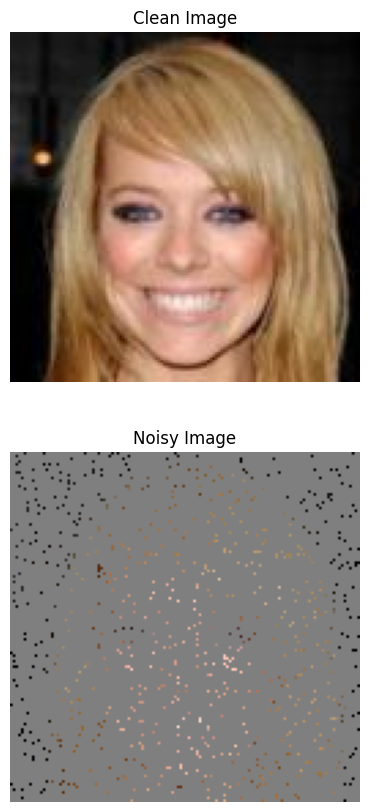

In [245]:
# plot the images
plt.figure(figsize=(5, 10))
plt.subplot(2, 1, 1)
plt.imshow(torch.clip((clean_img[0].cpu() + 1) / 2, 0, 1).permute(1, 2, 0))
plt.axis('off')
plt.title('Clean Image')
plt.subplot(2, 1, 2)
plt.imshow(torch.clip((noisy_img[0].cpu() + 1) /
           2, 0, 1).permute(1, 2, 0), vmin=0, vmax=1)
plt.axis('off')
plt.title('Noisy Image')
plt.savefig('clean_noisy_image.png')
plt.show()

## Restore it with PnP-flow

### Define denoiser

In [246]:
def denoiser(x, t):
    return x + (1 - t.view(-1, 1, 1, 1)) * model(x, t)

### Run PnP-Flow

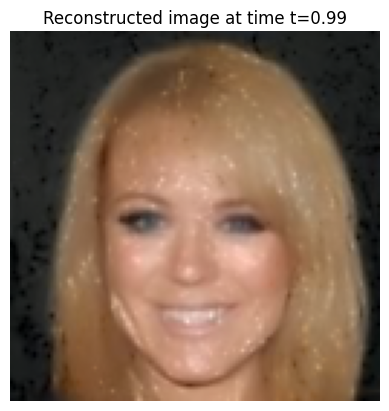

In [247]:
N = 100  # Number of time steps
alpha = 0.01  # Exponent in the learning rate
delta = 1 / N  # Time step size
x = torch.zeros((1, 3, 128, 128)).to(device)
fig, ax = plt.subplots()

for i in range(N):

    with torch.no_grad():

        t = torch.ones(len(x), device=device) * delta * i

        # Gradient step on the data-fidelity term
        lr_t = (1 - t)**alpha
        z = x - lr_t * H(H(x) - noisy_img)  # H is symmetric

        # Interpolation step
        z_tilde = t.view(-1, 1, 1, 1) * z + \
            torch.randn_like(x) * (1 - t.view(-1, 1, 1, 1))

        # Denoising step
        x_new = denoiser(z_tilde, t)

        # Update the solution
        x = x_new.clone()

        # Plot the current image
        if i % 5 == 0 or i == N - 1:
            clear_output(wait=True)
            ax.imshow(torch.clip((x[0].cpu() + 1) / 2,
                      0, 1).permute(1, 2, 0), vmin=0, vmax=1)
            ax.axis('off')
            ax.set_title(
                'Reconstructed image at time t={:4.2f}'.format(delta * i))
            display(fig)

clear_output(wait=False)

In [219]:
PSNR(clean_img, x).item()

6.3477678298950195

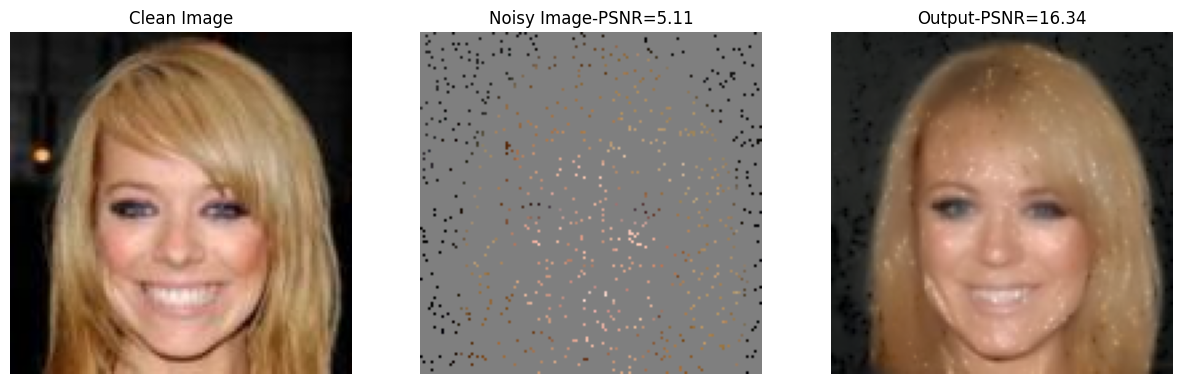

In [248]:
# plot the images
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(torch.clip((clean_img[0].cpu() + 1) / 2, 0, 1).permute(1, 2, 0))
plt.axis('off')
plt.title('Clean Image')
plt.subplot(1, 3, 2)
plt.imshow(torch.clip((noisy_img[0].cpu() + 1) /
           2, 0, 1).permute(1, 2, 0), vmin=0, vmax=1)
plt.axis('off')
plt.title(f'Noisy Image-PSNR={PSNR(noisy_img, clean_img).item():.2f}')
plt.subplot(1, 3, 3)
plt.imshow(torch.clip((x[0].cpu() + 1) /
           2, 0, 1).permute(1, 2, 0), vmin=0, vmax=1)
plt.axis('off')
plt.title(f'Output-PSNR={PSNR(clean_img, x).item():.2f}')
plt.savefig('mask.png')

### Experiment with different parameters

In [ ]:
def sample(N, alpha, delta, x, noisy_img, k):
    for i in range(N):
        with torch.no_grad():

            t = torch.ones(len(x), device=device) * delta * i

            # Gradient step on the data-fidelity term
            lr_t = (1 - t)**alpha
            z = x - lr_t * H(H(x) - noisy_img)  # H is symmetric

            # Interpolation step
            z = z.repeat(k, 1, 1, 1)
            z_tilde = t.view(-1, 1, 1, 1) * z + \
                torch.randn_like(x) * (1 - t.view(-1, 1, 1, 1))

            # Denoising step
            x_new = denoiser(z_tilde, t.repeat(k))

            x_new = x_new.mean(0).unsqueeze(0)
            # Update the solution
            x = x_new.clone()
    return PSNR(clean_img, x).item()

In [24]:
import time

N = 100  # Number of time steps
alpha = 0.01  # Exponent in the learning rate
delta = 1 / N  # Time step size
x = torch.zeros((1, 3, 128, 128)).to(device)
k = np.arange(1, 30)
times = np.zeros(len(k))
psnrs = np.zeros(len(k))

for i in range(len(k)):
    t0 = time.time()
    psnrs[i] = sample(N, alpha, delta, x, noisy_img, denoiser, k[i])
    times[i] = time.time() - t0



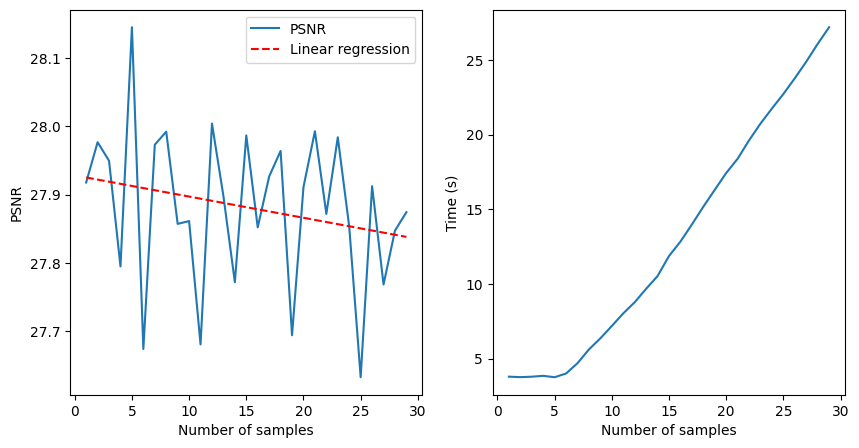

In [27]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(k, psnrs)
#plot linear regression
z = np.polyfit(k, psnrs, 1)
p = np.poly1d(z)
plt.plot(k, p(k), "r--")
plt.legend(['PSNR', 'Linear regression'])
plt.xlabel('Number of samples')
plt.ylabel('PSNR')
plt.subplot(1, 2, 2)
plt.plot(k, times)
plt.xlabel('Number of samples')
plt.ylabel('Time (s)')
plt.savefig('esperance.pdf')

### Heun Sampler

In [ ]:
import torch
import matplotlib.pyplot as plt
from IPython.display import clear_output, display

N = 50  # Number of time steps
alpha = 0.01  # Exponent in the learning rate
delta = 1 / N  # Time step size
x = torch.zeros((1, 3, 128, 128)).to(device)
fig, ax = plt.subplots()

for i in range(N):
    with torch.no_grad():
        t = torch.ones(len(x), device=device) * delta * i  # Current time step

        # Gradient step on the data-fidelity term
        lr_t = (1 - t) ** alpha
        z = x - lr_t * H(H(x) - noisy_img)  # H is symmetric

        # Interpolation step
        z_tilde = t.view(-1, 1, 1, 1) * z + \
                  torch.randn_like(x) * (1 - t.view(-1, 1, 1, 1))

        # Predictor step (Euler)
        x_pred = z_tilde + (1 - t.view(-1, 1, 1, 1))*0.5 * model(z_tilde, t)
        #x_new = x_pred + (1 - t.view(-1, 1, 1, 1)) * 0.5 * model(x_pred, (1+t)/2)
        # # Corrector step (Heun's method)
        model_z_tilde = model(z_tilde, t)
        model_x_pred = model(x_pred, (1+t)/2)
        x_new = z_tilde + (1 - t.view(-1, 1, 1, 1)) * 0.5 * (model_z_tilde + model_x_pred)

        # Update the solution
        x = x_new.clone()

        # Plot the current image
        if i % 5 == 0 or i == N - 1:
            clear_output(wait=True)
            ax.imshow(torch.clip((x[0].cpu() + 1) / 2, 0, 1).permute(1, 2, 0), vmin=0, vmax=1)
            ax.axis('off')
            ax.set_title(f'Reconstructed image at time t={delta * i:.2f}')
            display(fig)

clear_output(wait=False)


In [33]:
PSNR(clean_img, x).item()

23.665103912353516

### Wrong denoiser

In [92]:
model_cat = UNet(input_channels=3,
                 input_height=256,
                 ch=32,
                 ch_mult=(1, 2, 4, 8),
                 num_res_blocks=6,
                 attn_resolutions=(16, 8),
                 resamp_with_conv=True,
                 )
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_cat.load_state_dict(torch.load('model_final_cat.pt', map_location=device))
model_cat.to(device)
model_cat.eval()

UNet(
  (act): Swish()
  (temb_net): TimestepEmbedding(
    (main): Sequential(
      (0): Linear(in_features=32, out_features=128, bias=True)
      (1): Swish()
      (2): Linear(in_features=128, out_features=128, bias=True)
    )
  )
  (begin_conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (down_modules): ModuleList(
    (0): ModuleDict(
      (0a_0a_block): ResidualBlock(
        (act): Swish()
        (temb_proj): Linear(in_features=128, out_features=32, bias=True)
        (norm1): GroupNorm(32, 32, eps=1e-06, affine=True)
        (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm2): GroupNorm(32, 32, eps=1e-06, affine=True)
        (dropout): Identity()
        (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (shortcut): Identity()
      )
      (0a_1a_block): ResidualBlock(
        (act): Swish()
        (temb_proj): Linear(in_features=128, out_features=32, bias=True)
        (norm1)

In [99]:
def denoiser_cat(x, t):
    return x + (1 - t.view(-1, 1, 1, 1)) * model_cat(x, t)

In [223]:
image_path = 'ted.jpg'
clean_img = Image.open(image_path)

# Define the transformation
transform = v2.Compose([
    v2.ToTensor(),
    v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Apply the transformation
clean_img = transform(clean_img).unsqueeze(0).to(device)

In [235]:
from pnpflow.utils import square_mask, random_mask, paintbrush_mask, gaussian_blur, gaussian_2d_kernel, downsample, upsample, bicubic_filter, create_downsampling_matrix


# Create a random mask with 70% missing pixels
mask = np.random.rand(256, 256) > 0.7
mask_tensor = torch.tensor(mask, dtype=torch.float32).unsqueeze(
    0).unsqueeze(0).to(device)

# Blur 
kernel_size = 21
sigma_blur = 3
kernel = gaussian_2d_kernel(sigma_blur, kernel_size).to(device)
filter = torch.zeros(
            (1, 3) + (256, 256), device=device
        )

filter[..., : kernel_size, : kernel_size] = kernel
filter = torch.roll(filter, shifts=(-(kernel_size-1)//2, -(kernel_size-1)//2), dims=(2, 3))
fk = torch.fft.fft2(filter)

#Super resolution
sf = 4

# define the linear operator H


def H(x):
    return x * mask_tensor

def H_adj(x):
    return x
# def H(x):
#     return torch.real(torch.fft.ifft2(
#                 torch.fft.fft2(x.to(device)) * fk))
# def H_adj(x):
#     return torch.real(torch.fft.ifft2(torch.fft.fft2(x.to(device)) * torch.conj(fk)))

# def H(x):
#     return downsample(x, sf)

# def H_adj(x):
#     return upsample(x, sf)

# Apply the mask to the image tensor and add noise
sigma_noise = 0.001
noisy_img = H(clean_img) 
noisy_img = noisy_img + sigma_noise * torch.randn_like(noisy_img)


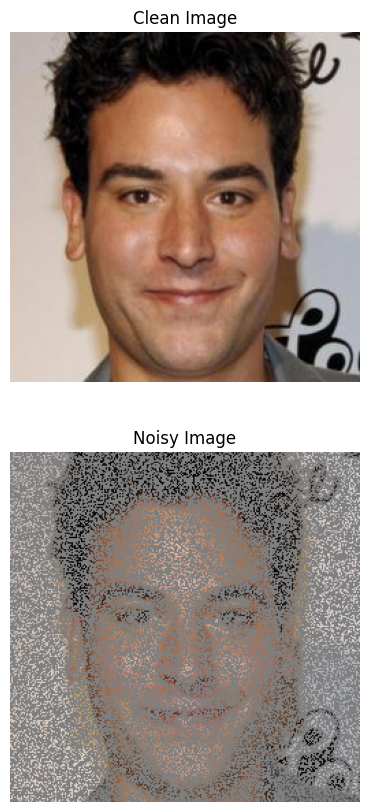

<Figure size 640x480 with 0 Axes>

In [236]:
# plot the images
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.imshow(torch.clip((clean_img[0].cpu() + 1) / 2, 0, 1).permute(1, 2, 0))
plt.axis('off')
plt.title('Clean Image')
plt.subplot(2, 1, 2)
plt.imshow(torch.clip((noisy_img[0].cpu() + 1) /
           2, 0, 1).permute(1, 2, 0), vmin=0, vmax=1)
plt.axis('off')
plt.title('Noisy Image')
plt.show()
plt.savefig('clean_noisy_image.png')

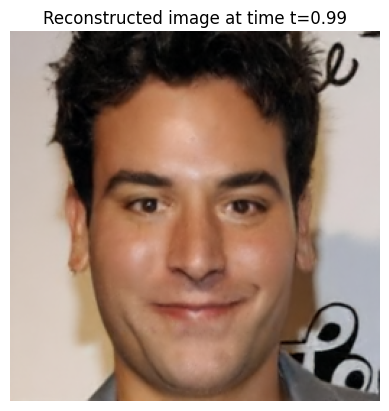

In [237]:
N = 100  # Number of time steps
alpha = 0.01  # Exponent in the learning rate
delta = 1 / N  # Time step size
x = torch.zeros((1, 3, 256, 256)).to(device)
fig, ax = plt.subplots()

for i in range(N):

    with torch.no_grad():

        t = torch.ones(len(x), device=device) * delta * i

        # Gradient step on the data-fidelity term
        lr_t = (1 - t)**alpha
        z = x - lr_t * H_adj(H(x) - noisy_img)  # H is symmetric

        # Interpolation step
        z_tilde = t.view(-1, 1, 1, 1) * z + \
            torch.randn_like(x) * (1 - t.view(-1, 1, 1, 1))

        # Denoising step
        x_new = denoiser_cat(z_tilde, t)

        # Update the solution
        x = x_new.clone()

        # Plot the current image
        if i % 5 == 0 or i == N - 1:
            clear_output(wait=True)
            ax.imshow(torch.clip((x[0].cpu() + 1) / 2,
                      0, 1).permute(1, 2, 0), vmin=0, vmax=1)
            ax.axis('off')
            ax.set_title(
                'Reconstructed image at time t={:4.2f}'.format(delta * i))
            display(fig)

clear_output(wait=False)

In [238]:
print(PSNR(clean_img, x).item())
print(PSNR(H_adj(noisy_img),clean_img).item())

28.705608367919922
6.933828353881836


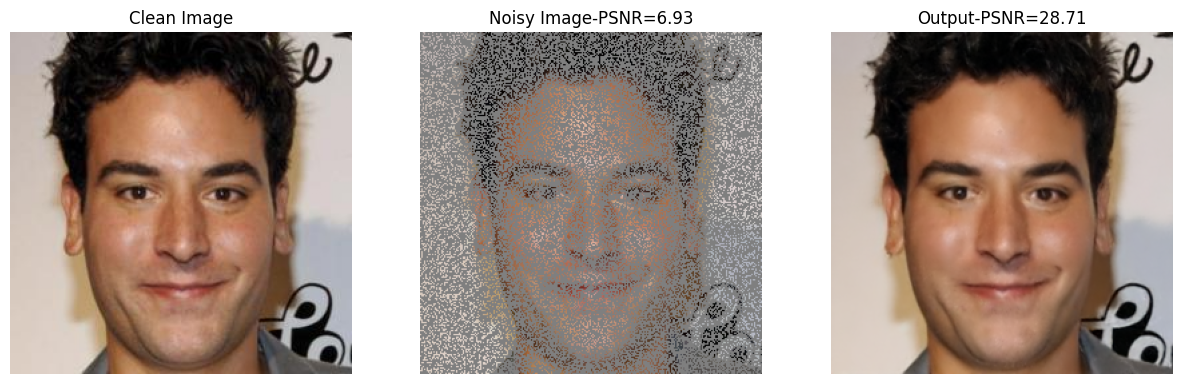

In [239]:
# plot the images
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(torch.clip((clean_img[0].cpu() + 1) / 2, 0, 1).permute(1, 2, 0))
plt.axis('off')
plt.title('Clean Image')
plt.subplot(1, 3, 2)
plt.imshow(torch.clip((noisy_img[0].cpu() + 1) /
           2, 0, 1).permute(1, 2, 0), vmin=0, vmax=1)
plt.axis('off')
plt.title(f'Noisy Image-PSNR={PSNR(H_adj(noisy_img), clean_img).item():.2f}')
plt.subplot(1, 3, 3)
plt.imshow(torch.clip((x[0].cpu() + 1) /
           2, 0, 1).permute(1, 2, 0), vmin=0, vmax=1)
plt.axis('off')
plt.title(f'Output-PSNR={PSNR(clean_img, x).item():.2f}')
plt.savefig('ted_cat_mask.png')

### Extreme situations